# Imports and Read Data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind
from tqdm import tqdm
import numpy as np
import math
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

def load_ipeds_unis(fname='../data/IPEDS/hd2020.csv', encoding='cp1252'):
    return pd.read_csv(fname, encoding=encoding)

def filter_only_rs_and_las(unis):
    unis = unis[unis['C18BASIC'].apply(lambda x: x in [15, 16, 17, 21, 22])]
    unis['Y']  = unis['C18BASIC'].apply(lambda x: 'liberal_arts' if x in [21, 22] else 'research')
    return unis

def preprocess_names(unis):
    ## Preprocessing meta-data files
    ### Updating names to match in rankings  
    unis.loc[unis['IALIAS'] =='Virginia Tech', 'INSTNM']                                            = 'Virginia Tech'
    unis.loc[unis['INSTNM'] =='University of Illinois Urbana-Champaign', 'INSTNM']                  = 'University of Illinois at Urbana-Champaign'
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='MD'), 'INSTNM']             = "St. John's College - MD"
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='NM'), 'INSTNM']             = "St. John's College - NM"
    unis.loc[unis['INSTNM'] =="William & Mary", 'INSTNM']                                           = "College of William and Mary"
    unis.loc[(unis['INSTNM']=="Brigham Young University") & (unis['CITY']=='Provo'), 'INSTNM']      = "Brigham Young University-Provo"
    unis.loc[(unis['INSTNM']=="The University of the South") & (unis['CITY']=='Sewanee'), 'INSTNM'] = "Sewanee - The University of the South"
    return unis

def fetch_rankings(fname='../data/US Higher Education_ Value vs. Vulnerability.xlsx', skiprows=5,\
                   usecols=['Institution Name', 'Full Time Enrollment', 'Ranking List', 'Rank'], top=-1):
    
    rankings = pd.read_excel(fname,skiprows=skiprows, usecols=usecols)
    
    if top > -1:
        rankings = rankings[rankings['Rank']<=top]
        
    return rankings

unis     = load_ipeds_unis()
# unis     = filter_only_rs_and_las(unis)
# unis     = preprocess_names(unis)

# rankings = fetch_rankings(top=100)

# merged   = pd.merge(unis, rankings, left_on='INSTNM', right_on='Institution Name')

# print("Missing unis: %s " % set(rankings['Institution Name']).difference(merged['INSTNM']))

# CS and Non-CS

In [3]:

fnames         = glob('../data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')
fnames         = [fname for fname in fnames if ('2000' not in fname) and ('2001' not in fname)]
dfs            = [pd.read_csv(fname, index_col=0) for fname in fnames]
dfs            = [df.rename(columns={col: col.upper().strip() for col in df.columns}) for df in dfs]
dfs            = [df[df['AWLEVEL']==5] for df in dfs]
cs_maps        = [df['CIPCODE'].apply(lambda x: (x>=11) & (x<12)) for df in dfs]
cs_maps        = [cs_map.rename('CS') for cs_map in cs_maps] 
cs_and_noncs   = [df.groupby([cs_maps[i], df.index]).sum().reset_index() for i, df in enumerate(dfs)]


years          = [int(fname.split('/')[-1].split('_')[0][1:]) for fname in fnames]
cs_and_noncs   = sorted(zip(years, cs_and_noncs), key=lambda x: x[0])

cs_and_noncs   = [(year, df.rename(columns={col: col.upper().strip() for col in df.columns})) for year, df in cs_and_noncs]
cs_and_noncs  = [(year, pd.merge(unis[['UNITID', 'OBEREG']], df, on='UNITID')) for year, df in cs_and_noncs]
# cs_and_noncs2  = [(year, pd.merge(unis[['UNITID', 'STABBR']], df, on='UNITID')) for year, df in cs_and_noncs]

# Black Students 1

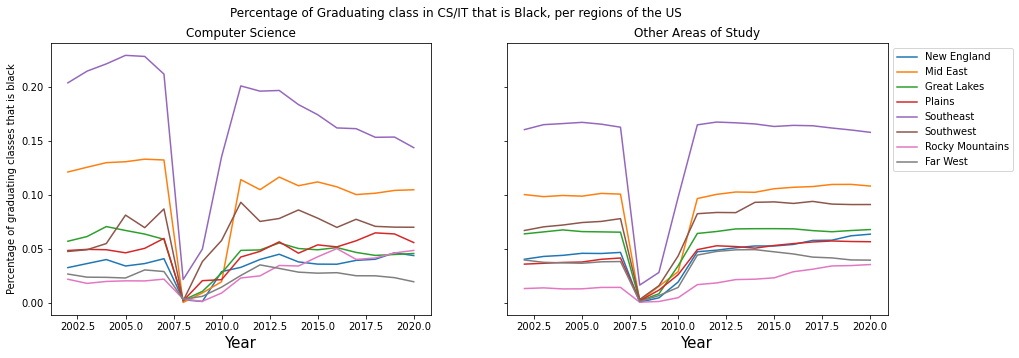

In [4]:
var, var_alt   = 'CBKAAT', 'CRACE18' 
black_pct      = [df.groupby(['CS', 'OBEREG']).apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum()).reset_index().rename(columns={0:year})\
                    for year, df in cs_and_noncs]

concatentated = pd.concat(black_pct, axis=1)
concatentated = concatentated.T.drop_duplicates().T

cs = concatentated[concatentated['CS']==True]
cs = cs[cs['OBEREG'].apply(lambda x: x in range(1, 9))]
noncs = concatentated[concatentated['CS']==False]
noncs = noncs[noncs['OBEREG'].apply(lambda x: x in range(1, 9))]

fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

cs.apply(lambda x: axs[0].plot(x[years].sort_index(), label=x['OBEREG']), axis=1);

noncs.apply(lambda x: axs[1].plot(x[years].sort_index(), label=x['OBEREG']), axis=1);
plt.legend(['New England',
            'Mid East',
            'Great Lakes ',
            'Plains',
            'Southeast',
            'Southwest',
            'Rocky Mountains',
            'Far West'], loc='upper left', bbox_to_anchor=(1, 1))

axs[0].set_xlabel('Year', fontsize=15);
axs[1].set_xlabel('Year', fontsize=15);
axs[0].set_ylabel('Percentage of graduating classes that is black');
axs[0].set_title('Computer Science');
axs[1].set_title('Other Areas of Study');
plt.suptitle('Percentage of Graduating class in CS/IT that is Black, per regions of the US');

# Black Students 2

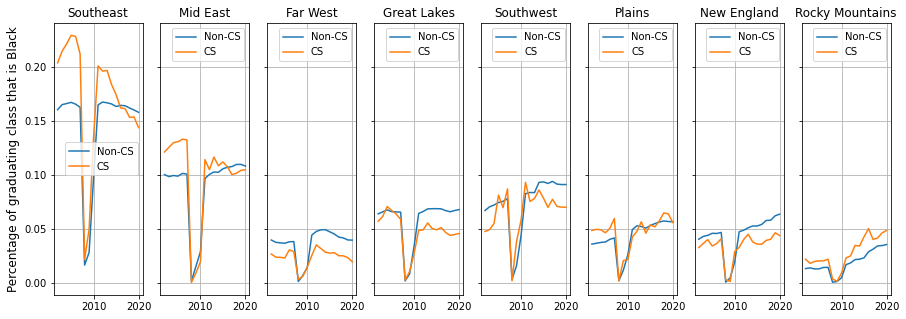

In [5]:
var, var_alt   = 'CBKAAT', 'CRACE18' 
black_pct      = [df.groupby(['CS', 'OBEREG']).apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum()).reset_index().rename(columns={0:year})\
                    for year, df in cs_and_noncs]

concatentated = pd.concat(black_pct, axis=1)
concatentated = concatentated.T.drop_duplicates().T

cs = concatentated[concatentated['CS']==True]
cs = cs[cs['OBEREG'].apply(lambda x: x in range(1, 9))]
noncs = concatentated[concatentated['CS']==False]
noncs = noncs[noncs['OBEREG'].apply(lambda x: x in range(1, 9))]

fig, axs = plt.subplots(1,len(cs), figsize=(15, 5), sharex=True, sharey=True)

# years = list(range(2014, 2021))
years = list(range(2002, 2021))

regions = {1: "New England", 2: "Mid East", 3: "Great Lakes", 4: "Plains", 5: "Southeast", 6: "Southwest", 7: "Rocky Mountains", 8: "Far West"}

cs['OBEREG'] = cs['OBEREG'].apply(lambda x: regions[x])
noncs['OBEREG'] = noncs['OBEREG'].apply(lambda x: regions[x])

regions = ['Southeast',
            'Mid East',
            'Far West',
            'Great Lakes',
            'Southwest',
            'Plains',
            'New England',
            'Rocky Mountains']

for i, region in enumerate(regions):
    axs[i].plot(noncs[noncs['OBEREG']==region][years].iloc[0].sort_index(), label='Non-CS');
    axs[i].plot(cs[cs['OBEREG']==region][years].iloc[0].sort_index(), label='CS');
    axs[i].set_title(region);
    axs[i].grid()
    axs[i].legend();

axs[0].set_ylabel('Percentage of graduating class that is Black', fontsize=12);
# plt.suptitle('Percentage of graduating classes that is Black, per regions of the US');


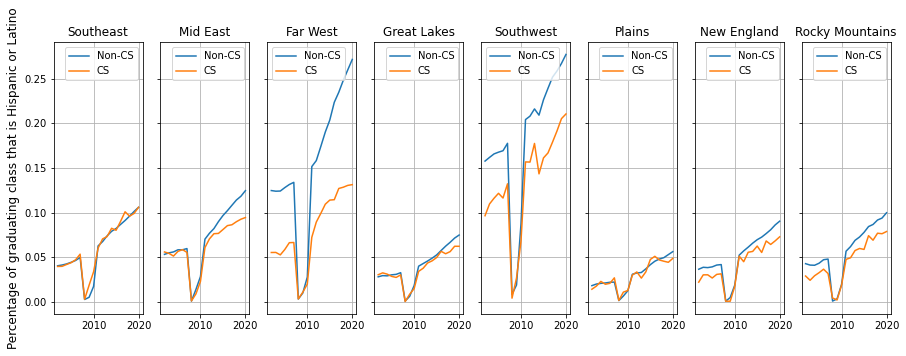

In [6]:
var, var_alt   = 'CHISPT', 'CRACE21'
hispanic_pct      = [df.groupby(['CS', 'OBEREG']).apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum()).reset_index().rename(columns={0:year})\
                    for year, df in cs_and_noncs]

concatentated = pd.concat(hispanic_pct, axis=1)
concatentated = concatentated.T.drop_duplicates().T

cs = concatentated[concatentated['CS']==True]
cs = cs[cs['OBEREG'].apply(lambda x: x in range(1, 9))]
noncs = concatentated[concatentated['CS']==False]
noncs = noncs[noncs['OBEREG'].apply(lambda x: x in range(1, 9))]

fig, axs = plt.subplots(1,len(cs), figsize=(15, 5), sharex=True, sharey=True)

# years = list(range(2014, 2021))
years = list(range(2002, 2021))

regions         = {1: "New England", 2: "Mid East", 3: "Great Lakes", 4: "Plains", \
                    5: "Southeast", 6: "Southwest", 7: "Rocky Mountains", 8: "Far West"}
cs['OBEREG']    = cs['OBEREG'].apply(lambda x: regions[x])
noncs['OBEREG'] = noncs['OBEREG'].apply(lambda x: regions[x])

regions = ['Southeast',
            'Mid East',
            'Far West',
            'Great Lakes',
            'Southwest',
            'Plains',
            'New England',
            'Rocky Mountains']

for i, region in enumerate(regions):
    axs[i].plot(noncs[noncs['OBEREG']==region][years].iloc[0].sort_index(), label='Non-CS');
    axs[i].plot(cs[cs['OBEREG']==region][years].iloc[0].sort_index(), label='CS');
    axs[i].set_title(regions[i]);
    axs[i].grid()
    axs[i].legend();

axs[0].set_ylabel('Percentage of graduating class that is Hispanic or Latino', fontsize=12);
# plt.suptitle('Percentage of graduating classes that is Hispanic or Latino, per regions of the US');


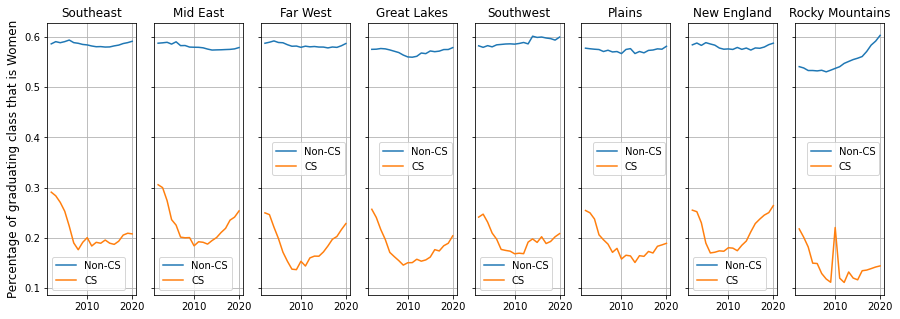

In [7]:
var, var_alt   = 'CTOTALW', 'CRACE16' 
women_pct      = [df.groupby(['CS', 'OBEREG']).apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())      if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()   if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum()).reset_index().rename(columns={0:year})\
                    for year, df in cs_and_noncs]

concatentated = pd.concat(women_pct, axis=1)
concatentated = concatentated.T.drop_duplicates().T

cs = concatentated[concatentated['CS']==True]
cs = cs[cs['OBEREG'].apply(lambda x: x in range(1, 9))]
noncs = concatentated[concatentated['CS']==False]
noncs = noncs[noncs['OBEREG'].apply(lambda x: x in range(1, 9))]

fig, axs = plt.subplots(1,len(cs), figsize=(15, 5), sharex=True, sharey=True)

# years = list(range(2014, 2021))
years = list(range(2002, 2021))

regions         = {1: "New England", 2: "Mid East", 3: "Great Lakes", 4: "Plains", \
                    5: "Southeast", 6: "Southwest", 7: "Rocky Mountains", 8: "Far West"}
cs['OBEREG']    = cs['OBEREG'].apply(lambda x: regions[x])
noncs['OBEREG'] = noncs['OBEREG'].apply(lambda x: regions[x])

regions = ['Southeast',
            'Mid East',
            'Far West',
            'Great Lakes',
            'Southwest',
            'Plains',
            'New England',
            'Rocky Mountains']

for i, region in enumerate(regions):
    axs[i].plot(noncs[noncs['OBEREG']==region][years].iloc[0].sort_index(), label='Non-CS');
    axs[i].plot(cs[cs['OBEREG']==region][years].iloc[0].sort_index(), label='CS');
    axs[i].set_title(regions[i]);
    axs[i].grid()
    axs[i].legend();

axs[0].set_ylabel('Percentage of graduating class that is Women', fontsize=12);
# plt.suptitle('Percentage of graduating classes that is Women, per regions of the US');


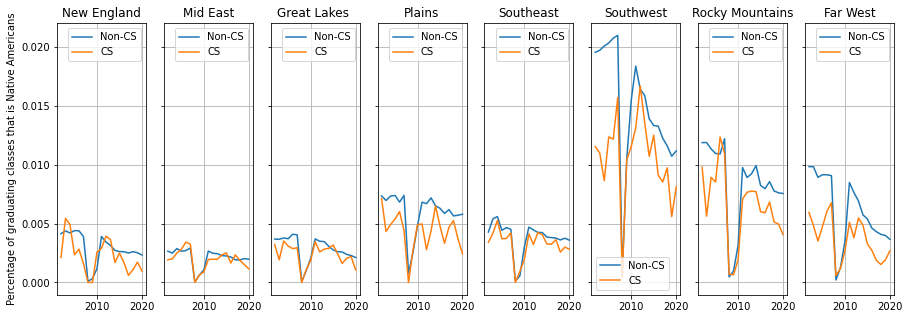

In [8]:
var, var_alt   = 'CAIANT', 'CRACE19'
natives_pct      = [df.groupby(['CS', 'OBEREG']).apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum()).reset_index().rename(columns={0:year})\
                    for year, df in cs_and_noncs]

concatentated = pd.concat(natives_pct, axis=1)
concatentated = concatentated.T.drop_duplicates().T

cs = concatentated[concatentated['CS']==True]
cs = cs[cs['OBEREG'].apply(lambda x: x in range(1, 9))]
noncs = concatentated[concatentated['CS']==False]
noncs = noncs[noncs['OBEREG'].apply(lambda x: x in range(1, 9))]

fig, axs = plt.subplots(1,len(cs), figsize=(15, 5), sharex=True, sharey=True)

years = list(range(2002, 2021))

regions = ['New England', 'Mid East', 'Great Lakes ', 'Plains','Southeast', 'Southwest','Rocky Mountains','Far West']

for i, region in enumerate(cs['OBEREG'].unique()):
    axs[i].plot(noncs[noncs['OBEREG']==region][years].iloc[0].sort_index(), label='Non-CS');
    axs[i].plot(cs[cs['OBEREG']==region][years].iloc[0].sort_index(), label='CS');
    axs[i].set_title(regions[i]);
    axs[i].grid()
    axs[i].legend();

axs[0].set_ylabel('Percentage of graduating classes that is Native Americans');
# plt.suptitle('Percentage of graduating classes that are Native Americans, per regions of the US');
